In [ ]:
'''
This notebook focuses on pre-processing and creating a baseline model to improve upon
Pre-processing includes:
 - Dummy encoding
 - Imputation
 - Removal of columns with high missing variables

Logistic regression model applied (no optimisation)
Accuracy -> ___%
'''

In [1]:
# numpy and pandas for data manipulation
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Imputer

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor


In [2]:
def save_pickle(path, data):
    # pickles the tokens dict
    with open(path, "wb") as f:
        pickle.dump(data, f)
    print("File saved at ", path)


def load_pickle(path):
    # loads the tokens dict from directory
    with open(path, "rb") as f:
        return pickle.load(f)
    print("File loaded: ", path)

In [3]:
def load_training_data():
    app_train = pd.read_csv('../input/application_train.csv')
    print('Training data shape: ', app_train.shape)
    return app_train


def load_test_data():
    # Testing data features
    app_test = pd.read_csv('../input/application_test.csv')
    print('Testing data shape: ', app_test.shape)
    return app_test

train_data = load_training_data()
test_data = load_test_data()

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [4]:
def encode_binary_cols(app_train, app_test):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0
    encoded_cols = []
    # Iterate through the columns
    for col in app_train:
        if app_train[col].dtype == 'object':
            # If 2 or fewer unique categories (a nan will count as a category)
            if len(list(app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(app_train[col])
                # Transform both training and testing data
                app_train[col] = le.transform(app_train[col])
                app_test[col] = le.transform(app_test[col])
                encoded_cols.append(col)

                # Keep track of how many columns were label encoded
                le_count += 1
                
train_data, test_data = encode_binary_cols(train_data, test_data)

TypeError: 'NoneType' object is not iterable

In [20]:
def one_hot_encode(app_train, app_test):
    # one-hot encoding of categorical variables
    # Dummy encoding will not create a column for nans
    app_train = pd.get_dummies(app_train)
    app_test = pd.get_dummies(app_test)

    print("ONE HOT ENCODED")
    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test

train_data, test_data = one_hot_encode(train_data, test_data)

ONE HOT ENCODED
Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)


In [21]:
def align_data(app_train, app_test):
    # ALIGN TEST AND TRAIN DATAFRAMES SO COLUMNS MATCH
    train_labels = app_train['TARGET']

    # Align the training and testing data, keep only columns present in both dataframes
    app_train, app_test = app_train.align(app_test, join='inner', axis=1)

    # Add the target back in
    app_train['TARGET'] = train_labels

    print("ALIGNED:")
    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test, train_labels

train_data, test_data, train_Y = align_data(train_data, test_data)

ALIGNED:
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


There were 0 anomalies in the test data out of 48744 entries


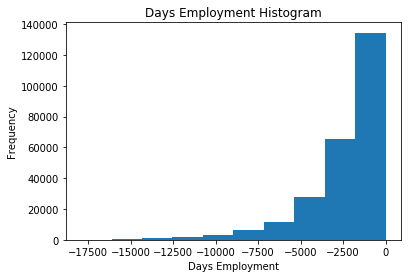

In [22]:
def remove_days_employed_anomaly(app_train, app_test):
    # DEALING WITH ANOMALOUS DATA IN 'DAYS_EMPLOYED' COL

    # Create an anomalous flag column
    app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
    # Replace the anomalous values with nan
    app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

    app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
    plt.xlabel('Days Employment');

    app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
    app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

    print('There were %d anomalies in the test data out of %d entries' % (
        app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))
    return app_train, app_test

train_data, test_data = remove_days_employed_anomaly(train_data, test_data)

In [30]:
def normalise_and_impute(app_train, app_test, impute_strategy='mean'):
    # Drop the target from the training data
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
    else:
        train = app_train.copy()
    train = train.drop(columns=['SK_ID_CURR'])  #

    test = app_test.copy()
    test = test.drop(columns=['SK_ID_CURR'])  #

    # Feature names
    features = list(train.columns)

    # Median imputation of missing values
    imputer = Imputer(strategy=impute_strategy)
    # Fit on the training data
    imputer.fit(train)
    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(test)  ### test was app_test

    # Normalise
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale each feature to 0-1
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print("IMPUTED AND NORMALISED")
    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)
    return train, test, features

# train_X and test_X are np arrays
# train_X, test_X, feature_names = normalise_and_impute(train_data, test_data, impute_strategy='mean')

IMPUTED AND NORMALISED
Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [8]:
def create_and_save_submission(app_test, predictions, save_path):
    # Submission dataframe
    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = predictions

    # Save the submission to a csv file
    submit.to_csv(save_path, index=False)
    print("Predictions saved to: ", save_path)

In [9]:
def baseline_log_reg(train, train_Y, test, save_path):
    # Make the model with the specified regularization parameter
    log_reg = LogisticRegression(C=0.0001)

    # Train on the training data
    log_reg.fit(train, train_Y)

    # Make predictions - only require 2nd columns (representing the probability that the target is 1)
    log_reg_pred = log_reg.predict_proba(test)[:, 1]

    # Save model
    save_pickle("../models/log_reg_new.pickle", log_reg)  # save model
    print("Log reg baseline model saved to: ", save_path)
    return log_reg, log_reg_pred

# model, preds = baseline_log_reg(train_X, train_Y, test_X, save_path="../models/test.pickle")
# create_and_save_submission(test_data, preds, save_path='../test_predictions/test.csv')

In [10]:
def random_search_log_reg(train, train_Y, test, save_path):
    '''
    Mean imputation
    Best Penalty: l2
    Best C: 1.668088018810296
    test acc -> 0.73846
    '''
    model = LogisticRegression()

    # Search parameters and search space
    penalty = ['l1', 'l2']
    C = uniform(loc=0, scale=4)
    hyperparameters = dict(C=C, penalty=penalty)

    # Create randomized search 5-fold cross validation and 100 iterations
    clf = RandomizedSearchCV(model, hyperparameters, random_state=1, n_iter=5, cv=5, verbose=1)
    # Fit randomized search
    best_model = clf.fit(train, train_Y)

    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'])

    predictions = best_model.predict_proba(test)[:, 1]

    # Save model
    save_pickle("../models/log_reg_new.pickle", model)  # save model
    print("Log reg baseline model saved to: ", save_path)

    return model, predictions

# model, preds = random_search_log_reg(train_X, train_Y, test_X, save_path="../models/test.pickle")
# create_and_save_submission(test_data, preds, save_path='../test_predictions/test.csv')

In [ ]:
def cross_val_roc_curve(train_X, train_Y, classifier):
    # From https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

    # ROC AUC with stratified cross validation
    X = train_X
    y = train_Y

    cv = StratifiedKFold(n_splits=6, shuffle=True)
    tprs = []  # true positive rate scores
    aucs = []  # area under curve scores
    mean_fpr = np.linspace(0, 1, 100)  # mean false positive rates

    i = 0
    # train and test for each fold
    for train_sample, test_sample in cv.split(X, y):
        probas_ = classifier.fit(X[train_sample], y[train_sample]).predict_proba(X[test_sample])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test_sample], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print("Run {} AUC socre: {}".format(i, roc_auc))

        '''Everything below this point is just for the plot'''
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    # plot roc curve for fold
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    # caluclate and plot mean auc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # plot standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # add labels to plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    print("Avg ROC AUC score: {}".format(np.mean(aucs)))

# model = load_pickle("../models/log_reg_new.pickle")
# train_X, test_X, feature_names = normalise_and_impute(train_data, test_data, impute_strategy='mean')
# cross_val_roc_curve(train_X, train_Y, model) 

IMPUTED AND NORMALISED
Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)
Run 0 AUC socre: 0.7455418539019963
Run 1 AUC socre: 0.7482204392069075
Run 2 AUC socre: 0.7434560943702402
Run 3 AUC socre: 0.7437869495647487


In [13]:
def feature_aic_bic(app_train, feature_name: str):
    # calculates the aic and bic values between the target and a column
    # http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/

    data = app_train.copy()
    data = data[[feature_name, "TARGET"]]

    # Median imputation of missing values
    imputer = Imputer(strategy='mean')
    imputer.fit(data)
    imputed_data = imputer.transform(data)
    data[feature_name] = imputed_data

    data["intercept"] = 1.0
    logit = sm.Logit(data["TARGET"], data[feature_name])
    result = logit.fit()

    # result.summary2() # uncomment for full summary
    print("Selected Feature", feature_name)
    print("AIC", result.aic)
    print("BIC", result.bic)

    # 168863, 0.274561 - ext3 mean
model = load_pickle("../models/log_reg_opt.pickle")
feature_aic_bic(train_data, "EXT_SOURCE_3")

Optimization terminated successfully.
         Current function value: 0.274561
         Iterations 7
Selected Feature EXT_SOURCE_3
AIC 168863.02936295504
BIC 168873.66562909298


In [49]:
def imputed_col_aic(data, feature_name):
#     data["intercept"] = 1.0
    logit = sm.Logit(data["TARGET"], data[feature_name])
    result = logit.fit()
    print("AIC", result.aic)

In [15]:
def get_top_correlations(app_train, feature, n=15):
    correlations = app_train.corr()[feature]
    correlations = abs(correlations).sort_values().tail(
        n)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations.keys()



In [27]:
def top_corr_knn_imputation(top_corrs, feature: str, app_train, app_test):
#     top_corrs = get_top_correlations(train_data, feature, n=10)  # TODO -> uncomment once working

    # create training data from columns with values
    not_null_mask = app_train[feature].notna()  # true if not nan = mask to get the values to train on
    train_x = app_train[not_null_mask][
        top_corrs]  # get all top corr cols (minus target) which have a ext_source_3 value
    train_y = app_train[not_null_mask][[feature]]

    # imputation of missing values for the other columns
    imputer = Imputer(strategy='mean')
    train_x = imputer.fit_transform(train_x)

    # get the rows which require imputation
    test_x = app_train[app_train[feature].isna()][top_corrs]  # only null values
    imputer = Imputer(strategy='mean')
    test_x = imputer.fit_transform(test_x)

    # as above but for the app_test data
    app_test_x = app_test[app_test[feature].isna()][top_corrs]  # only null values
    imputer = Imputer(strategy='mean')
    app_test_x = imputer.fit_transform(app_test_x)

    # train and predict
    neigh = KNeighborsRegressor(n_neighbors=150)
    neigh.fit(train_x, train_y)
    y_test = neigh.predict(test_x)
    y_app_test = neigh.predict(app_test_x)

    # get the column to update nulls
    filled_col = app_train[[feature]]
    filled_col[filled_col[feature].isna()] = y_test
    # fill column
    data = app_train.copy()
    data[feature] = filled_col

    # get the column to update nulls for app_test
    filled_col_app_test = app_test[[feature]]
    filled_col_app_test[filled_col_app_test[feature].isna()] = y_app_test
    # fill column
    data_app_test = app_test.copy()
    data_app_test[feature] = filled_col_app_test

    imputed_col_aic(data, feature)
    return data, data_app_test

In [53]:
top_corrs = get_top_correlations(train_data, 'EXT_SOURCE_3', n=15)

In [52]:
def log_reg_knn_imputation(top_corrs, feat_name, app_train, app_test, model_save_path, predications_save_path):
#     top_corrs = get_top_correlations(train_data, 'EXT_SOURCE_3', n=15)
    train_Y = app_train['TARGET']
    train_X, test_X = top_corr_knn_imputation(top_corrs, feat_name, app_train, app_test)
    train_X, test_X, feat_names = normalise_and_impute(train_X, test_X,
                                                       impute_strategy='mean')

    model, preds = baseline_log_reg(train_X, train_Y, test_X, save_path=model_save_path)
    create_and_save_submission(test_data, preds, save_path=predications_save_path)

    
log_reg_knn_imputation(top_corrs, 'EXT_SOURCE_3', train_data, test_data,
                       model_save_path="../models/test.pickle",
                       predications_save_path='../test_predictions/test.csv') 
# test score -> 0.67843 (using baseline params)

Optimization terminated successfully.
         Current function value: 0.273478
         Iterations 7
AIC 168196.7461043481
IMPUTED AND NORMALISED
Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)
File saved at  ../models/log_reg_new.pickle
Log reg baseline model saved to:  ../models/test.pickle
Predictions saved to:  ../test_predictions/test.csv
